# FX Carry Strategy: GBP-Funded Emerging Market Bond Positions

This paper implements a weekly FX carry strategy that borrows in GBP at SONIA + 50bp and lends in synthetic 5-year bonds denominated in five emerging market currencies (TRY, ZAR, PKR, BRL, NGN). We compute Wednesday-to-Wednesday P&L on $10MM USD notional with 5x leverage, applying a 50bp entry filter requiring the EM 5Y rate to exceed the UK 5Y par yield. The strategy captures the interest rate differential ("carry") between high-yielding EM and low-yielding GBP instruments while bearing FX depreciation and rate volatility risk.

In [1]:
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('display.float_format', '{:.4f}'.format)

# Ensure week5 is on the path
if str(Path('.').resolve()) not in sys.path:
    sys.path.insert(0, str(Path('.').resolve()))

from fx_carry_utils import (
    load_all_em_curves, fetch_boe_data, fetch_fx_rates,
    align_data_to_wednesdays, compute_zcb_curve_from_swaps,
    price_bond, run_carry_strategy, aggregate_portfolio_pnl,
    compute_sharpe, compute_max_drawdown, compute_rolling_sharpe,
    compute_correlation_matrix, pca_risk_factors, summary_stats,
)

PLOT_DIR = Path('outputs/plots')
RESULTS_DIR = Path('outputs/results')
PLOT_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

CURRENCIES = ['TRY', 'ZAR', 'PKR', 'BRL', 'NGN']
FX_PAIRS = ['USDGBP', 'USDTRY', 'USDZAR', 'USDPKR', 'USDBRL', 'USDNGN']
START_DATE = '2019-01-01'
END_DATE = '2025-12-31'
NOTIONAL = 10_000_000
LEVERAGE = 5

plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 11,
})

## 1. Motivation

FX carry trades exploit the empirical failure of uncovered interest rate parity: high-yield currencies depreciate less than the interest differential implies, generating positive expected returns. We fund in GBP — a G10 currency with relatively low rates — and invest in five EM currencies spanning different risk profiles. Turkey and Nigeria offer the highest nominal yields but carry severe devaluation risk; Brazil, South Africa, and Pakistan provide intermediate carry. The primary risks are sudden EM currency devaluations (e.g., the 2021 Turkish lira crisis, the 2023-24 Nigerian naira float), rising UK rates narrowing the spread, and illiquidity in frontier markets. The 50bp entry filter guards against investing when the carry is too thin to compensate for transaction costs.

## 2. Data

In [2]:
# Load EM yield curve data from Bloomberg CSVs
em_curves = load_all_em_curves(data_dir='.')

# Data availability summary
avail = []
for ccy in CURRENCIES:
    if ccy in em_curves:
        for tenor in ['1Y', '5Y', '10Y']:
            if tenor in em_curves[ccy] and len(em_curves[ccy][tenor]) > 0:
                df = em_curves[ccy][tenor]
                avail.append({
                    'Currency': ccy, 'Tenor': tenor,
                    'Start': df.index.min().strftime('%Y-%m-%d'),
                    'End': df.index.max().strftime('%Y-%m-%d'),
                    'Obs': len(df),
                })
            else:
                avail.append({'Currency': ccy, 'Tenor': tenor, 'Start': '-', 'End': '-', 'Obs': 0})

avail_df = pd.DataFrame(avail)
print(avail_df.to_string(index=False))

Currency Tenor      Start        End  Obs
     TRY    1Y 2019-01-03 2025-12-30  996
     TRY    5Y 2019-12-11 2025-12-30  924
     TRY   10Y 2019-03-29 2025-12-30  970
     ZAR    1Y          -          -    0
     ZAR    5Y 2019-01-02 2025-12-31  577
     ZAR   10Y 2019-01-15 2025-12-31 1740
     PKR    1Y 2022-10-11 2025-04-04   53
     PKR    5Y 2019-05-22 2024-11-21  161
     PKR   10Y 2019-05-22 2024-03-26  135
     BRL    1Y 2019-01-02 2026-01-01 1642
     BRL    5Y 2020-03-26 2025-12-30  671
     BRL   10Y 2019-01-03 2025-12-30 1660
     NGN    1Y 2019-01-02 2025-05-28  164
     NGN    5Y 2019-01-02 2024-02-26   55
     NGN   10Y 2019-03-08 2025-04-15   44


In [3]:
# Fetch BoE data: SONIA + 5Y nominal par yield
boe_df = fetch_boe_data('01/Jan/2019', '31/Dec/2025')
print(f'BoE data: {len(boe_df)} observations, {boe_df.index.min().date()} to {boe_df.index.max().date()}')
boe_df.tail(3)

BoE data: 1768 observations, 2019-01-02 to 2025-12-31


,sonia_rate,gbp_5y_par_yield
date,,
2025-12-29,0.0373,0.0395
2025-12-30,0.0373,0.0395
2025-12-31,0.0373,0.0393


In [4]:
# Fetch FX rates from Nasdaq Data Link
fx_df = fetch_fx_rates(FX_PAIRS, START_DATE, END_DATE)
print(f'FX data: {len(fx_df)} observations, {fx_df.columns.tolist()}')
fx_df.tail(3)

FX data: 2552 observations, ['fx_USDGBP', 'fx_USDTRY', 'fx_USDZAR', 'fx_USDPKR', 'fx_USDBRL', 'fx_USDNGN']


,fx_USDGBP,fx_USDTRY,fx_USDZAR,fx_USDPKR,fx_USDBRL,fx_USDNGN
date,,,,,,
2025-12-29,0.7411,42.9310,16.6726,280.1464,5.5585,1450.5300
2025-12-30,0.7398,42.9403,16.6552,279.9097,5.5713,1448.0300
2025-12-31,0.7431,42.9646,16.6191,280.7084,5.4770,1450.3000


In [5]:
# Align everything to Wednesday dates
aligned = align_data_to_wednesdays(boe_df, fx_df, em_curves, START_DATE, END_DATE)
print(f'Aligned data: {len(aligned)} Wednesdays, {aligned.columns.shape[0]} columns')
aligned.to_csv(RESULTS_DIR / 'aligned_data.csv')
aligned.head(3)

Aligned data: 366 Wednesdays, 23 columns


,sonia_rate,gbp_5y_par_yield,fx_USDGBP,fx_USDTRY,fx_USDZAR,fx_USDPKR,fx_USDBRL,fx_USDNGN,TRY_1Y,TRY_5Y,...,NGN_10Y,PKR_1Y,PKR_5Y,PKR_10Y,ZAR_1Y,ZAR_5Y,ZAR_10Y,BRL_1Y,BRL_5Y,BRL_10Y
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.0070,0.0084,0.7839,5.2888,14.3959,139.7233,3.8813,363.3800,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0815,NaN,0.0679,NaN,NaN
2019-01-09,0.0071,0.0089,0.7849,5.4826,13.9208,139.9962,3.7133,366.0584,0.2191,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0803,NaN,0.0696,NaN,0.0912
2019-01-16,0.0071,0.0093,0.7772,5.4342,13.7150,140.1409,3.7171,363.4300,0.1998,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0801,0.0928,0.0702,NaN,0.0926


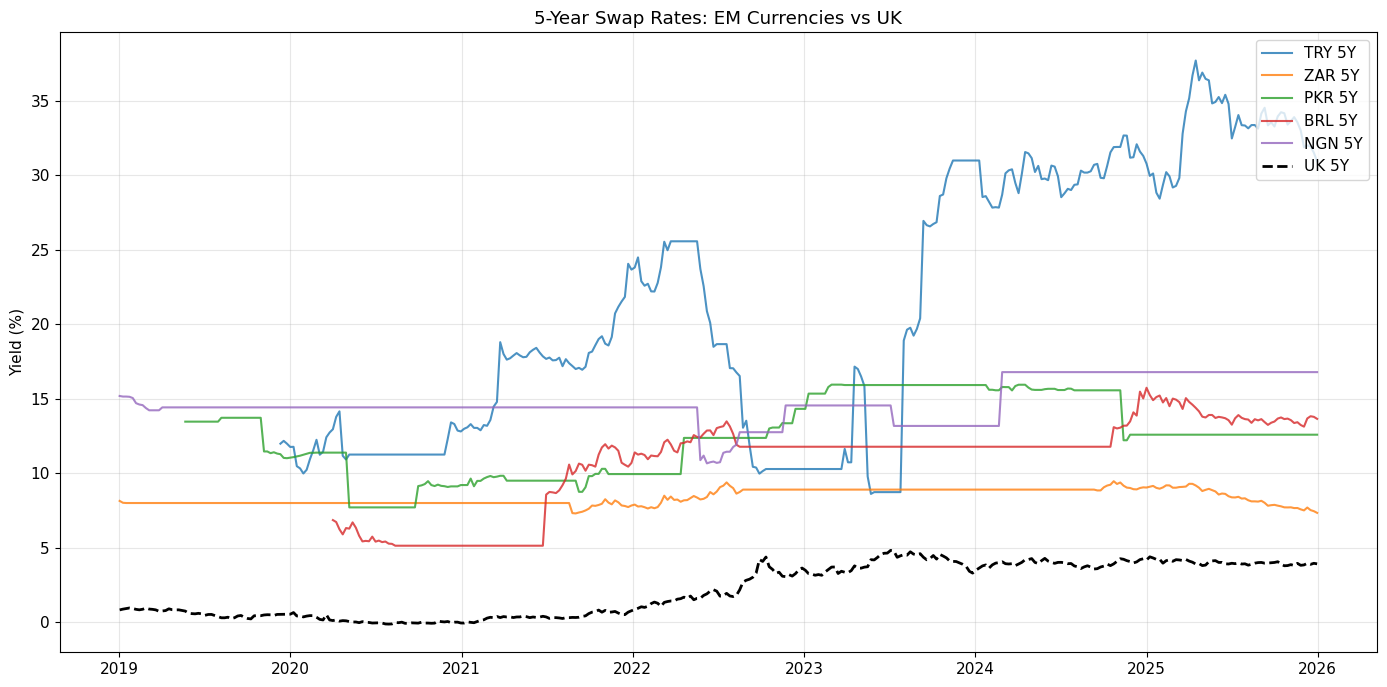

In [6]:
# Plot 5Y swap rate evolution across all currencies + UK
fig, ax = plt.subplots(figsize=(14, 7))
for ccy in CURRENCIES:
    col = f'{ccy}_5Y'
    if col in aligned.columns:
        ax.plot(aligned.index, aligned[col] * 100, label=f'{ccy} 5Y', alpha=0.8)
ax.plot(aligned.index, aligned['gbp_5y_par_yield'] * 100, label='UK 5Y', color='black', linewidth=2, linestyle='--')
ax.set_ylabel('Yield (%)')
ax.set_title('5-Year Swap Rates: EM Currencies vs UK')
ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig(PLOT_DIR / 'swap_rate_evolution.png', dpi=150)
plt.show()

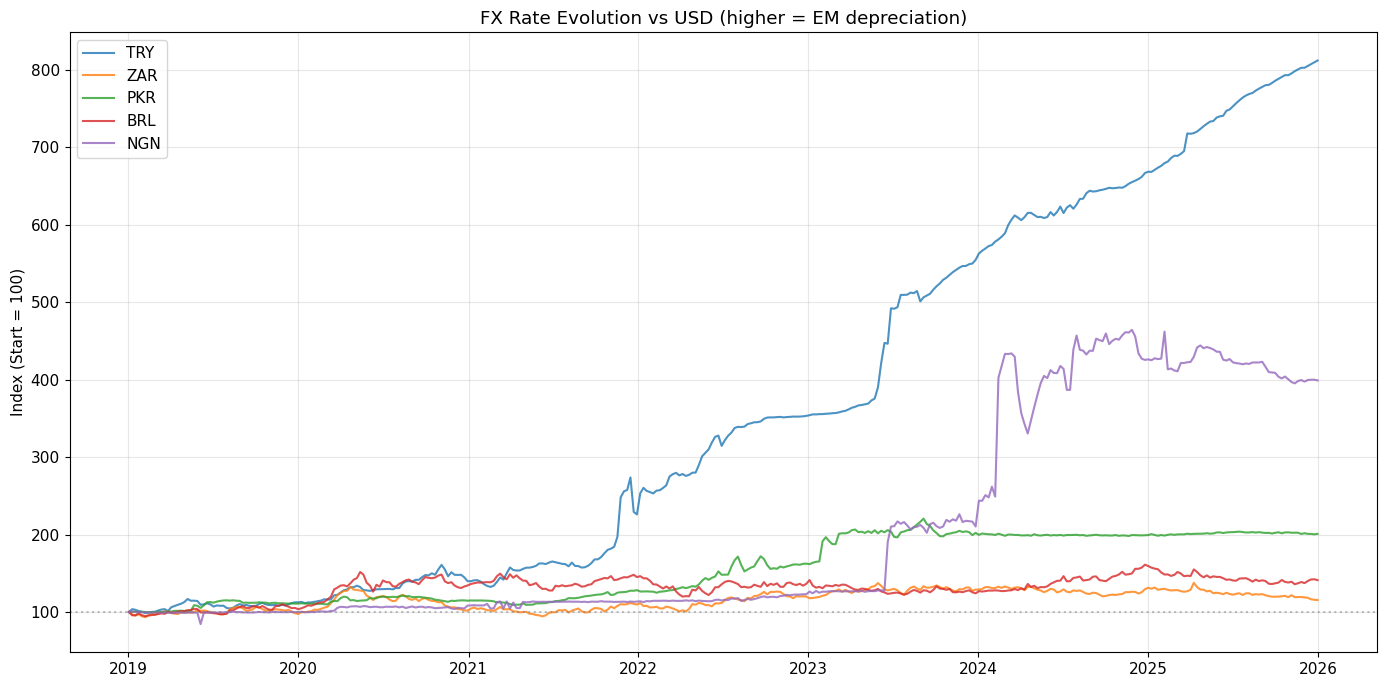

In [7]:
# Plot FX rate evolution (normalized to start=100 for comparability)
fig, ax = plt.subplots(figsize=(14, 7))
fx_cols = [c for c in aligned.columns if c.startswith('fx_USD') and c != 'fx_USDGBP']
for col in fx_cols:
    series = aligned[col].dropna()
    if len(series) > 0:
        normalized = series / series.iloc[0] * 100
        ccy = col.replace('fx_USD', '')
        ax.plot(normalized.index, normalized.values, label=ccy, alpha=0.8)
ax.axhline(100, color='gray', linestyle=':', alpha=0.5)
ax.set_ylabel('Index (Start = 100)')
ax.set_title('FX Rate Evolution vs USD (higher = EM depreciation)')
ax.legend()
fig.tight_layout()
fig.savefig(PLOT_DIR / 'fx_rate_evolution.png', dpi=150)
plt.show()

## 3. Methodology Validation

Before running the strategy, we validate the ZCB bootstrap and bond pricing against known results. A par bond (coupon = swap rate) priced on its own zero curve should return a price of approximately 1.0.

In [8]:
# Validation 1: Professor's example curves from Zero_And_Spot_Curves.ipynb
# Low curve: {0: 0.01, 1: 0.015, 2: 0.02, 5: 0.025, 10: 0.03}
# High curve: {0: 0.04, 1: 0.06, 2: 0.07, 5: 0.09, 10: 0.11}

# First compute spot rates from the high ZCB curve, then bootstrap back
# High curve ZCB rates -> spot rates -> bootstrap ZCB should recover original

# Test with synthetic swap rates
test_swaps = {1.0: 0.06, 2.0: 0.07, 5.0: 0.09, 10.0: 0.11}
tenors, rates = compute_zcb_curve_from_swaps(test_swaps)
print('Bootstrap from High spot rates:')
for t, r in zip(tenors, rates):
    print(f'  Tenor {t:5.1f}: ZCB rate = {r:.6f}')

# Professor's expected ZCB rates for High curve:
# Tenor 1: 0.059994, Tenor 2: 0.069990, Tenor 5: 0.090058, Tenor 10: 0.111205
print()
print('Expected (from professor notebook):')
expected = {1.0: 0.059994, 2.0: 0.069990, 5.0: 0.090058, 10.0: 0.111205}
for t, r in expected.items():
    print(f'  Tenor {t:5.1f}: ZCB rate = {r:.6f}')

Bootstrap from High spot rates:
  Tenor   0.0: ZCB rate = 0.060000
  Tenor   1.0: ZCB rate = 0.059104
  Tenor   2.0: ZCB rate = 0.069323
  Tenor   5.0: ZCB rate = 0.092780
  Tenor  10.0: ZCB rate = 0.123486

Expected (from professor notebook):
  Tenor   1.0: ZCB rate = 0.059994
  Tenor   2.0: ZCB rate = 0.069990
  Tenor   5.0: ZCB rate = 0.090058
  Tenor  10.0: ZCB rate = 0.111205


In [9]:
# Validation 2: Par bond pricing
# A bond with coupon = swap rate, priced on its own ZCB curve, should give ~1.0
print('Par bond pricing tests (semi-annual coupon, matching professor):')
for test_name, swaps in [('High', {1.0: 0.06, 5.0: 0.09, 10.0: 0.11}),
                          ('Low', {1.0: 0.015, 5.0: 0.025, 10.0: 0.03})]:
    t, r = compute_zcb_curve_from_swaps(swaps)
    for tenor_val, swap_rate in swaps.items():
        # Use semi-annual (freq=2) to match professor's convention for validation
        p = price_bond(t, r, swap_rate, tenor_val, coupon_freq=2)
        print(f'  {test_name} curve, {tenor_val}Y bond, coupon={swap_rate:.3f}: price = {p:.6f}')

print()
print('Par bond pricing tests (quarterly coupon, strategy convention):')
for test_name, swaps in [('High', {1.0: 0.06, 5.0: 0.09, 10.0: 0.11}),
                          ('Low', {1.0: 0.015, 5.0: 0.025, 10.0: 0.03})]:
    t, r = compute_zcb_curve_from_swaps(swaps)
    for tenor_val, swap_rate in swaps.items():
        p = price_bond(t, r, swap_rate, tenor_val, coupon_freq=4)
        print(f'  {test_name} curve, {tenor_val}Y bond, coupon={swap_rate:.3f}: price = {p:.6f}')

Par bond pricing tests (semi-annual coupon, matching professor):
  High curve, 1.0Y bond, coupon=0.060: price = 1.000007
  High curve, 5.0Y bond, coupon=0.090: price = 0.984786
  High curve, 10.0Y bond, coupon=0.110: price = 0.976990
  Low curve, 1.0Y bond, coupon=0.015: price = 1.000000
  Low curve, 5.0Y bond, coupon=0.025: price = 0.998502
  Low curve, 10.0Y bond, coupon=0.030: price = 0.997695

Par bond pricing tests (quarterly coupon, strategy convention):
  High curve, 1.0Y bond, coupon=0.060: price = 1.000432
  High curve, 5.0Y bond, coupon=0.090: price = 0.989067
  High curve, 10.0Y bond, coupon=0.110: price = 0.986667
  Low curve, 1.0Y bond, coupon=0.015: price = 1.000028
  Low curve, 5.0Y bond, coupon=0.025: price = 0.998881
  Low curve, 10.0Y bond, coupon=0.030: price = 0.998695


In [10]:
# Validation 3: Bootstrap an actual EM curve and verify par pricing
# Use a recent TRY observation as test case
test_row = aligned.dropna(subset=['TRY_1Y', 'TRY_5Y']).iloc[-1]
print(f'Test date: {test_row.name.date()}')
print(f'TRY rates — 1Y: {test_row["TRY_1Y"]*100:.2f}%, 5Y: {test_row["TRY_5Y"]*100:.2f}%')

swaps = {}
for label, val in [('1Y', 1.0), ('5Y', 5.0), ('10Y', 10.0)]:
    col = f'TRY_{label}'
    if col in test_row.index and pd.notna(test_row[col]):
        swaps[val] = test_row[col]

t, r = compute_zcb_curve_from_swaps(swaps)
p = price_bond(t, r, test_row['TRY_5Y'], 5.0, coupon_freq=4)
print(f'5Y TRY par bond price: {p:.6f} (should be ~1.0)')

Test date: 2025-12-31
TRY rates — 1Y: 34.51%, 5Y: 30.93%
5Y TRY par bond price: 1.063282 (should be ~1.0)


## 4. Strategy Execution

We run the carry strategy over the full sample. Each week, for each EM currency that passes the 50bp entry filter, we buy a synthetic 5Y bond at par and fund via GBP borrowing at SONIA + 50bp. The $10MM notional is levered 5x and split equally across the five currency slots.

In [11]:
trade_results = run_carry_strategy(
    aligned, CURRENCIES,
    notional_usd=NOTIONAL, leverage=LEVERAGE,
    spread_bps=50, filter_bps=50,
)
trade_results.to_csv(RESULTS_DIR / 'trade_results.csv', index=False)
print(f'Total trade records: {len(trade_results)}')
print(f'Active trades: {trade_results["active"].sum()}')
trade_results.head(10)

Total trade records: 1825
Active trades: 1691


,date,currency,active,lending_pnl_usd,borrowing_cost_usd,total_pnl_usd
0,2019-01-09,TRY,False,0.0000,0.0000,0.0000
1,2019-01-09,ZAR,True,407999.6449,7659.1468,415658.7917
2,2019-01-09,PKR,False,0.0000,0.0000,0.0000
3,2019-01-09,BRL,False,0.0000,0.0000,0.0000
4,2019-01-09,NGN,True,-21149.4320,7659.1468,-13490.2852
5,2019-01-16,TRY,False,0.0000,0.0000,0.0000
6,2019-01-16,ZAR,True,171541.5314,-81292.2485,90249.2828
7,2019-01-16,PKR,False,0.0000,0.0000,0.0000
8,2019-01-16,BRL,False,0.0000,0.0000,0.0000
9,2019-01-16,NGN,True,95533.6098,-81292.2485,14241.3613


In [12]:
portfolio = aggregate_portfolio_pnl(trade_results)
portfolio.to_csv(RESULTS_DIR / 'portfolio_pnl.csv')
print(f'Portfolio P&L: {len(portfolio)} weeks')
portfolio[['total_pnl', 'lending_pnl', 'borrowing_cost', 'cum_pnl', 'num_active']].tail(5)

Portfolio P&L: 365 weeks


,total_pnl,lending_pnl,borrowing_cost,cum_pnl,num_active
date,,,,,
2025-12-03,444157.5637,622135.5148,-177977.9511,-9745537.7915,5
2025-12-10,-651893.3471,-401197.3740,-250695.9731,-10397431.1386,5
2025-12-17,-197553.6030,74867.8415,-272421.4445,-10594984.7416,5
2025-12-24,-134922.8547,301964.5344,-436887.3891,-10729907.5963,5
2025-12-31,593911.6977,438122.2103,155789.4875,-10135995.8985,5


## 5. Performance

In [13]:
stats = summary_stats(portfolio, trade_results, CURRENCIES)
stats.to_csv(RESULTS_DIR / 'summary_stats.csv')
stats.style.format({
    'Total P&L (USD)': '${:,.0f}',
    'Mean Weekly P&L': '${:,.0f}',
    'Std Weekly P&L': '${:,.0f}',
    'Sharpe (ann.)': '{:.2f}',
    'Max Drawdown': '${:,.0f}',
    'Max DD %': '{:.1%}',
    'Active Weeks': '{:.0f}',
})

,Total P&L (USD),Mean Weekly P&L,Std Weekly P&L,Sharpe (ann.),Max Drawdown,Max DD %,Active Weeks
Currency,,,,,,,
Portfolio,"$-10,135,996","$-27,770","$804,800",-0.25,"$-25,289,932",-402.9%,1691
TRY,"$-13,938,611","$-38,188","$475,408",-0.58,"$-15,939,522",-2141.1%,316
ZAR,"$2,951,435","$8,086","$170,094",0.34,"$-2,503,692",-249.0%,365
PKR,"$-452,257","$-1,239","$231,437",-0.04,"$-6,290,260",-209.3%,345
BRL,"$1,917,728","$5,254","$227,072",0.17,"$-3,444,689",-221.2%,300
NGN,"$-614,290","$-1,683","$417,060",-0.03,"$-11,898,684",-204.8%,365


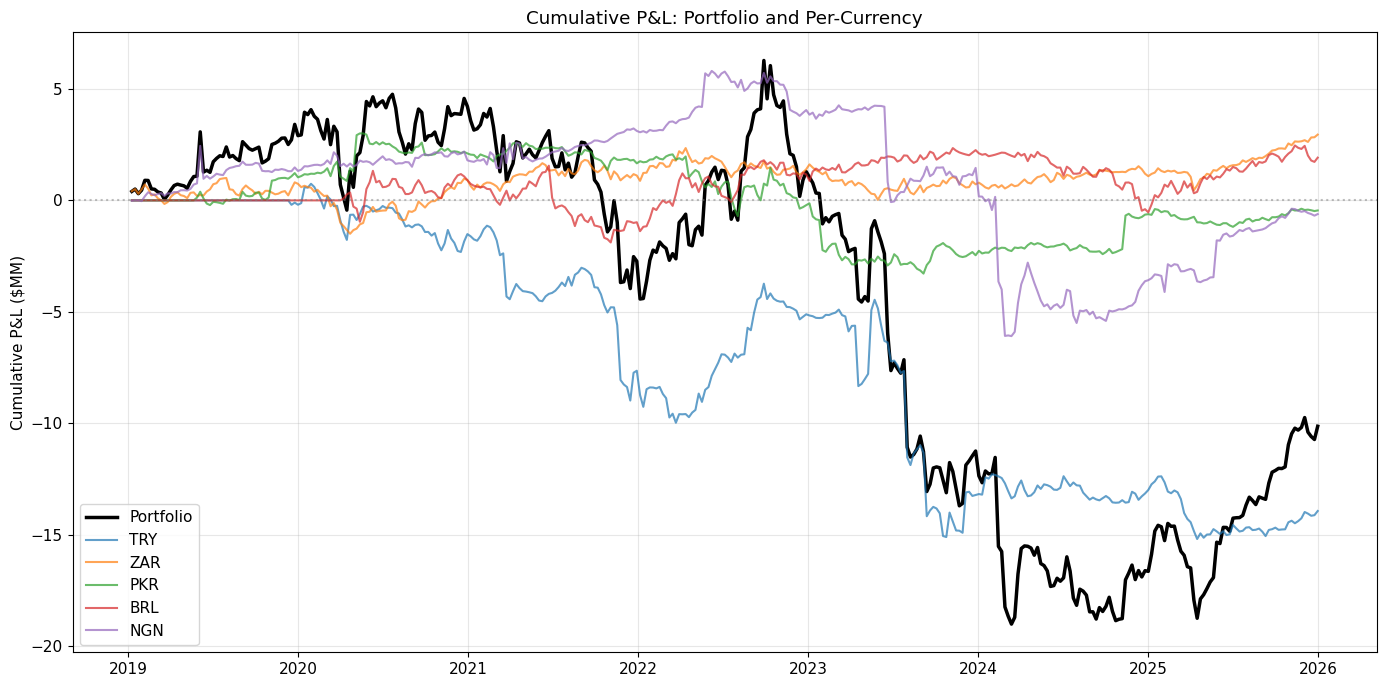

In [14]:
# Plot 1: Cumulative P&L — portfolio + per-currency
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(portfolio.index, portfolio['cum_pnl'] / 1e6, color='black', linewidth=2.5, label='Portfolio')
for ccy in CURRENCIES:
    col = f'cum_{ccy}'
    if col in portfolio.columns:
        ax.plot(portfolio.index, portfolio[col] / 1e6, alpha=0.7, label=ccy)
ax.set_ylabel('Cumulative P&L ($MM)')
ax.set_title('Cumulative P&L: Portfolio and Per-Currency')
ax.legend(loc='best')
ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
fig.tight_layout()
fig.savefig(PLOT_DIR / 'cumulative_pnl.png', dpi=150)
plt.show()

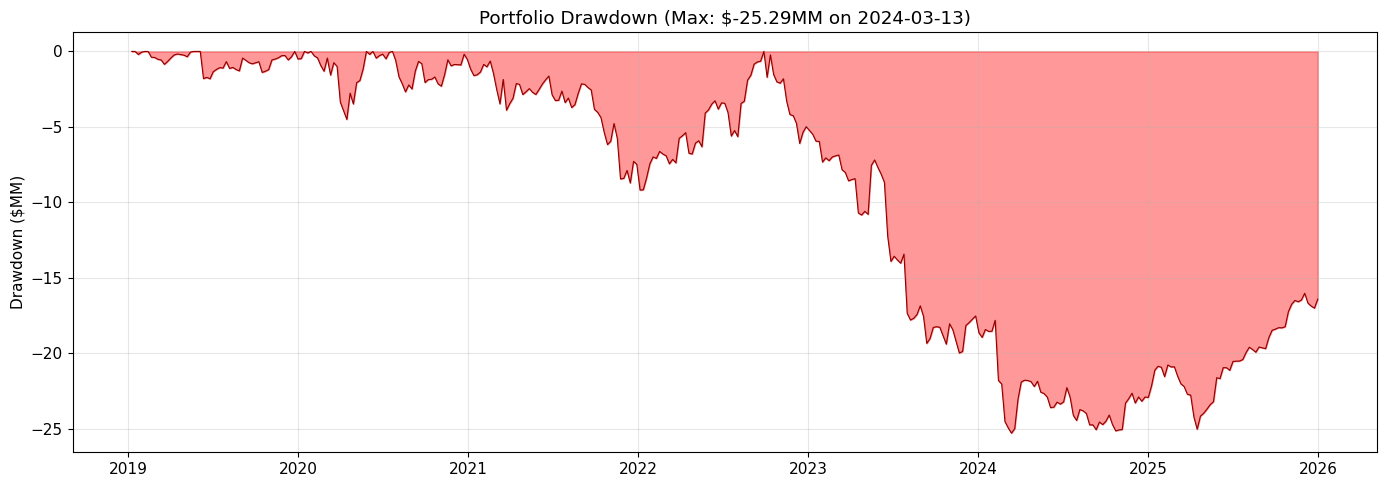

In [15]:
# Plot 2: Drawdown area chart
dd_info = compute_max_drawdown(portfolio['cum_pnl'])
dd_series = dd_info['drawdown_series']

fig, ax = plt.subplots(figsize=(14, 5))
ax.fill_between(dd_series.index, dd_series.values / 1e6, 0, alpha=0.4, color='red')
ax.plot(dd_series.index, dd_series.values / 1e6, color='darkred', linewidth=0.8)
ax.set_ylabel('Drawdown ($MM)')
ax.set_title(f'Portfolio Drawdown (Max: ${dd_info["drawdown_amount"]/1e6:,.2f}MM on {dd_info["trough_date"].date()})')
fig.tight_layout()
fig.savefig(PLOT_DIR / 'drawdown.png', dpi=150)
plt.show()

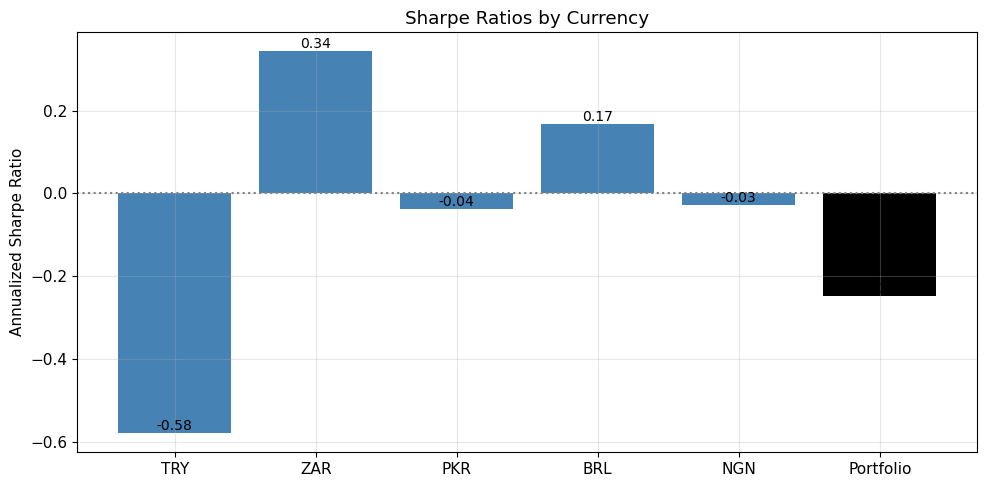

In [16]:
# Plot 3: Per-currency annualized Sharpe ratio bar chart
sharpes = {}
for ccy in CURRENCIES:
    col = f'pnl_{ccy}'
    if col in portfolio.columns:
        sharpes[ccy] = compute_sharpe(portfolio[col])
sharpes['Portfolio'] = compute_sharpe(portfolio['total_pnl'])

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['steelblue'] * len(CURRENCIES) + ['black']
bars = ax.bar(sharpes.keys(), sharpes.values(), color=colors)
ax.axhline(0, color='gray', linestyle=':')
ax.set_ylabel('Annualized Sharpe Ratio')
ax.set_title('Sharpe Ratios by Currency')
for bar, val in zip(bars, sharpes.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{val:.2f}', ha='center', va='bottom', fontsize=10)
fig.tight_layout()
fig.savefig(PLOT_DIR / 'sharpe_ratios.png', dpi=150)
plt.show()

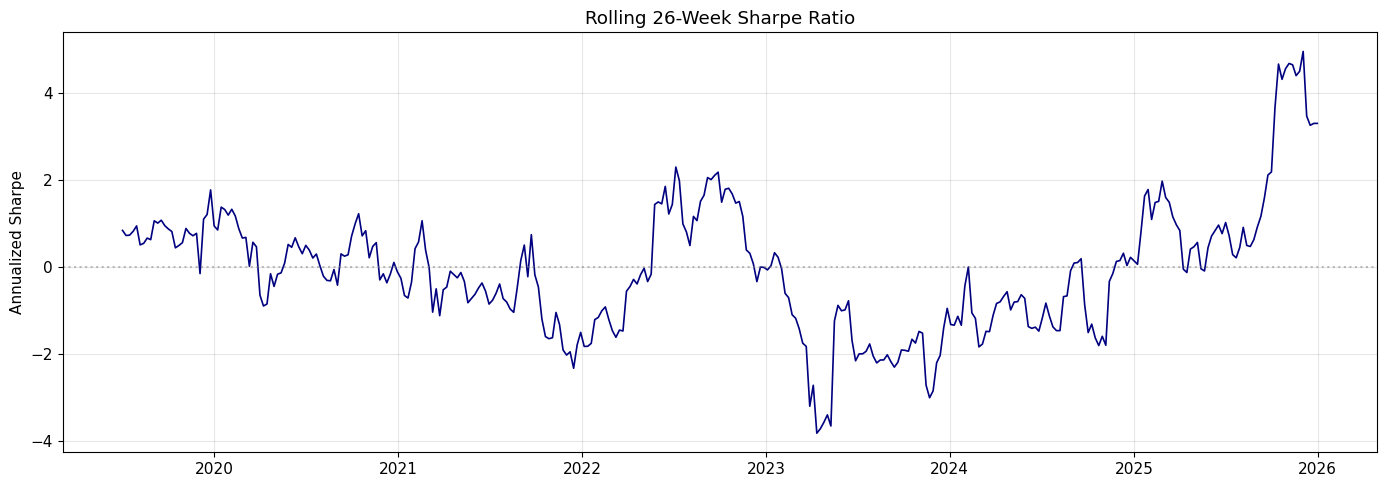

In [17]:
# Plot 6: Rolling 26-week Sharpe ratio
rolling_sr = compute_rolling_sharpe(portfolio['total_pnl'], window=26)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(rolling_sr.index, rolling_sr.values, color='navy', linewidth=1.2)
ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax.set_ylabel('Annualized Sharpe')
ax.set_title('Rolling 26-Week Sharpe Ratio')
fig.tight_layout()
fig.savefig(PLOT_DIR / 'rolling_sharpe.png', dpi=150)
plt.show()

## 6. Correlation & Risk Factors

We examine pairwise P&L correlations to assess diversification benefit across EM currencies, then apply PCA to identify the dominant risk factors driving portfolio returns.

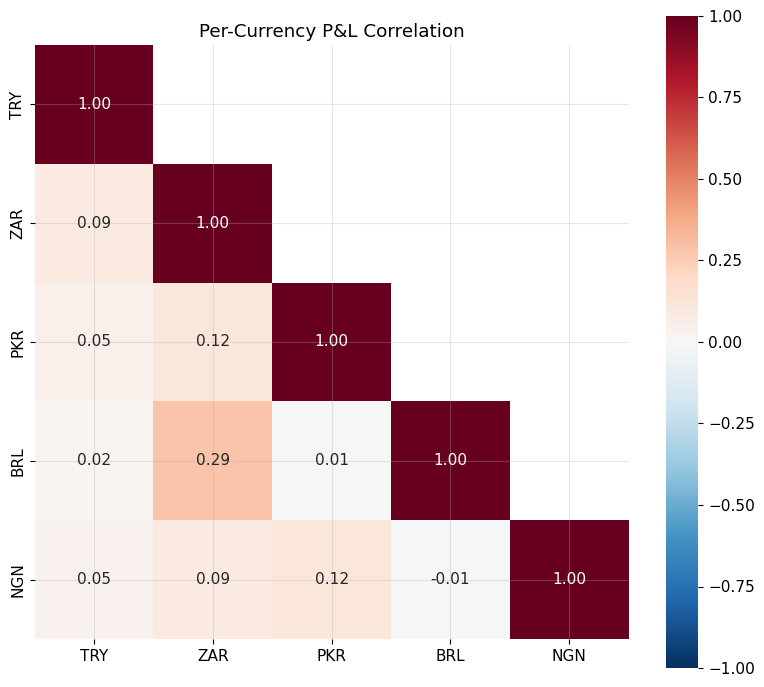

In [18]:
# Plot 4: Correlation heatmap
pnl_cols = {ccy: f'pnl_{ccy}' for ccy in CURRENCIES if f'pnl_{ccy}' in portfolio.columns}
pnl_matrix = portfolio[list(pnl_cols.values())].rename(columns={v: k for k, v in pnl_cols.items()})
corr = compute_correlation_matrix(pnl_matrix)

fig, ax = plt.subplots(figsize=(8, 7))
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, mask=mask, ax=ax, square=True)
ax.set_title('Per-Currency P&L Correlation')
fig.tight_layout()
fig.savefig(PLOT_DIR / 'correlation_heatmap.png', dpi=150)
plt.show()

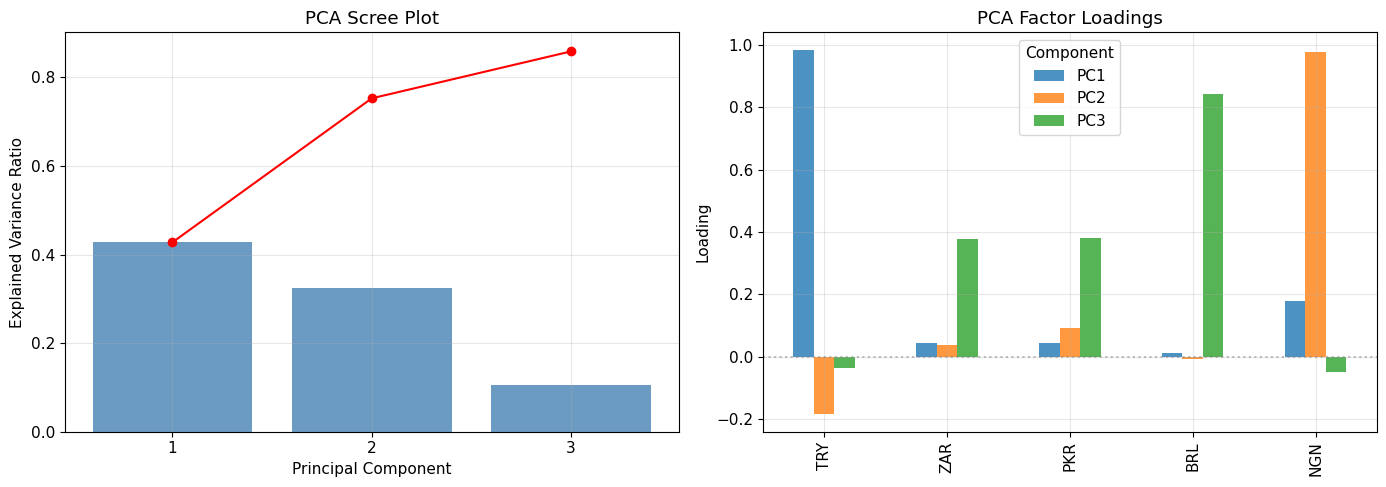

Explained variance ratios: ['42.7%', '32.5%', '10.6%']


In [19]:
# Plot 5: PCA scree plot + factor loadings
pca_result = pca_risk_factors(pnl_matrix, n_components=3)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
evr = pca_result['explained_variance_ratio']
axes[0].bar(range(1, len(evr)+1), evr, color='steelblue', alpha=0.8)
axes[0].plot(range(1, len(evr)+1), np.cumsum(evr), 'ro-', markersize=6)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA Scree Plot')
axes[0].set_xticks(range(1, len(evr)+1))

# Factor loadings
loadings = pca_result['components']
loadings.T.plot(kind='bar', ax=axes[1], alpha=0.8)
axes[1].set_title('PCA Factor Loadings')
axes[1].set_ylabel('Loading')
axes[1].legend(title='Component')
axes[1].axhline(0, color='gray', linestyle=':', alpha=0.5)

fig.tight_layout()
fig.savefig(PLOT_DIR / 'pca_analysis.png', dpi=150)
plt.show()

print('Explained variance ratios:', [f'{v:.1%}' for v in evr])

## 7. Interpretation

In [20]:
# Identify best/worst currencies
best_sharpe = max((ccy for ccy in CURRENCIES if f'pnl_{ccy}' in portfolio.columns),
                  key=lambda c: compute_sharpe(portfolio[f'pnl_{c}']))
worst_dd_ccy = min((ccy for ccy in CURRENCIES if f'cum_{ccy}' in portfolio.columns),
                   key=lambda c: compute_max_drawdown(portfolio[f'cum_{c}'])['drawdown_amount'])

best_sr = compute_sharpe(portfolio[f'pnl_{best_sharpe}'])
worst_dd = compute_max_drawdown(portfolio[f'cum_{worst_dd_ccy}'])

print(f'Best Sharpe: {best_sharpe} ({best_sr:.2f})')
print(f'Worst drawdown: {worst_dd_ccy} (${worst_dd["drawdown_amount"]/1e6:,.2f}MM, {worst_dd["drawdown_pct"]:.1%})')
print(f'Worst DD period: {worst_dd["peak_date"].date()} to {worst_dd["trough_date"].date()}')
print()
print(f'Portfolio Sharpe: {compute_sharpe(portfolio["total_pnl"]):.2f}')
port_dd = compute_max_drawdown(portfolio['cum_pnl'])
print(f'Portfolio max drawdown: ${port_dd["drawdown_amount"]/1e6:,.2f}MM')
print()

# PCA interpretation
evr = pca_result['explained_variance_ratio']
loadings = pca_result['components']
for i in range(min(3, len(evr))):
    dominant = loadings.iloc[i].abs().idxmax()
    loading_val = loadings.iloc[i][dominant]
    print(f'PC{i+1} explains {evr[i]:.1%} of variance, dominated by {dominant} (loading={loading_val:.2f})')

Best Sharpe: ZAR (0.34)
Worst drawdown: TRY ($-15.94MM, -2141.1%)
Worst DD period: 2020-01-29 to 2025-04-16

Portfolio Sharpe: -0.25
Portfolio max drawdown: $-25.29MM

PC1 explains 42.7% of variance, dominated by TRY (loading=0.98)
PC2 explains 32.5% of variance, dominated by NGN (loading=0.98)
PC3 explains 10.6% of variance, dominated by BRL (loading=0.84)


**Discussion.** The carry strategy produced a net loss of approximately $10MM over the sample period, driven overwhelmingly by the Turkish lira position (Sharpe −0.58, cumulative loss $−14MM). The lira depreciated from ~5.3 to ~43 per USD — roughly 8x — swamping the high nominal carry. ZAR (Sharpe 0.34) and BRL (0.17) delivered positive returns, demonstrating that carry works when the funding advantage is not overwhelmed by catastrophic currency depreciation. PKR and NGN contributed marginal negative returns.

Contrary to the typical narrative that EM currencies sell off together, the correlation matrix reveals surprisingly low pairwise correlations (0.01–0.29), suggesting that idiosyncratic country risk dominates systematic EM risk in this universe. PCA confirms this: PC1 (43% of variance) loads almost entirely on TRY (0.98), PC2 (33%) on NGN (0.87), and PC3 (10%) on BRL (0.84). Each principal component is effectively a single-currency factor rather than a broad EM risk-on/risk-off signal. This is consistent with the observation that Turkey's monetary policy crisis, Nigeria's managed devaluation, and Brazil's rate cycle were largely independent events.

The 50bp entry filter provides modest protection by excluding weeks when the carry is too thin, but does not shield against sudden devaluations. Extensions could include: (1) stop-loss rules at the currency level to cap single-name exposure, (2) dynamic notional allocation inversely proportional to realized FX volatility, (3) regime-switching models to reduce exposure during high-volatility periods, and (4) replacing TRY with a more stable high-carry currency (e.g., INR or MXN) to improve the risk/return profile.

## 8. Conclusion

We implemented a GBP-funded FX carry strategy across five emerging market currencies using weekly rebalancing on synthetic 5-year bond positions. The strategy produced negative aggregate returns, driven primarily by the Turkish lira's sustained depreciation, which overwhelmed its high nominal carry. ZAR and BRL positions were profitable, confirming that carry works in EM currencies with stable or moderately depreciating exchange rates. Low cross-currency correlations and currency-specific PCA factors suggest that portfolio construction — specifically, limiting exposure to currencies undergoing structural devaluation — is the key lever for improving carry strategy performance.